## scikit-learnで指標の確認

In [1]:
# 必要なモジュールの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('classification_imb.csv')
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x49,x50,x51,x52,x53,x54,x55,x56,x57,Target
0,0,2,0,0,6,1,0,0,0,0,...,4,3,9,0,1,1,0,1,0,1
1,1,3,8,0,0,1,0,0,0,0,...,3,3,8,0,1,1,1,1,0,1
2,2,1,1,1,0,0,0,0,1,0,...,1,2,8,0,1,1,1,0,0,1
3,5,1,9,0,0,1,0,0,0,0,...,1,3,8,0,1,1,0,0,0,1
4,0,1,2,0,0,1,0,0,0,0,...,0,3,6,0,1,0,1,0,1,1


In [3]:
df.shape

(29760, 58)

<Axes: xlabel='Target', ylabel='count'>

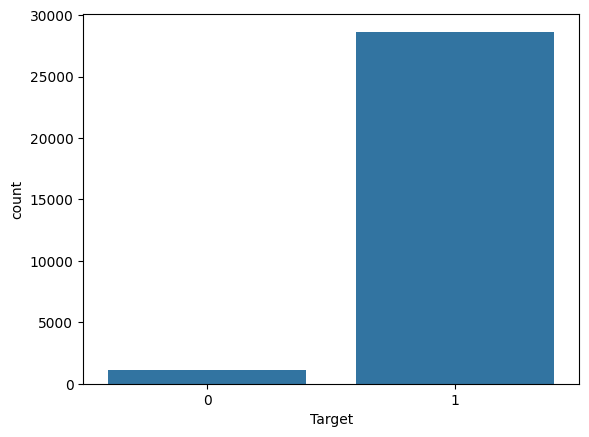

In [4]:
sns.countplot(df, x='Target')


In [5]:
x = df.drop('Target', axis=1).values
t = df['Target'].values

print(x.shape, t.shape)

(29760, 57) (29760,)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

## モデル構築

In [7]:
# モデルの定義
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [8]:
# モデルの学習
model.fit(x_train, t_train)

LogisticRegression()

In [9]:
# モデルの検証
print(model.score(x_train, t_train))
print(model.score(x_test, t_test))

0.9632776497695853
0.961581541218638


In [10]:
# 推論
y_pred = model.predict(x_test)

In [11]:
np.unique(t_test, return_counts=True)

(array([0, 1]), array([ 343, 8585]))

## 混同行列

In [12]:
from sklearn import metrics


In [13]:
# 混同行列の作成
labels = list(set(t))
c_matrix = metrics.confusion_matrix(t_test, y_pred, labels=labels)

In [14]:
c_matrix


array([[   0,  343],
       [   0, 8585]])

In [15]:
# DataFrameに整形
df_matrix = pd.DataFrame(c_matrix, columns=labels, index=labels)
df_matrix


,0,1
0,0,343
1,0,8585


Text(50.722222222222214, 0.5, 'Target')

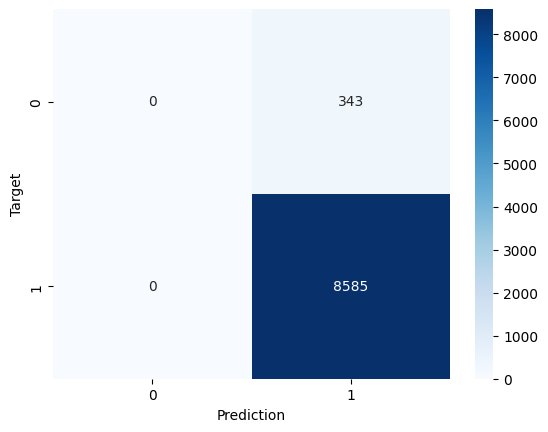

In [16]:
# ヒートマップで表示
sns.heatmap(df_matrix, annot=True, fmt='.0f', cmap='Blues');
plt.xlabel('Prediction')
plt.ylabel('Target')

## Precision・Recall・F1score

In [17]:
precision = metrics.precision_score(t_test, y_pred, average=None)
precision

array([0.        , 0.96158154])

In [18]:
recall = metrics.recall_score(t_test, y_pred, average=None)
recall

array([0., 1.])

In [19]:
f1_score = metrics.f1_score(t_test, y_pred, average=None)
f1_score

array([0.        , 0.98041455])

In [20]:
precision, recall, f1_score, total = metrics.precision_recall_fscore_support(t_test, y_pred)

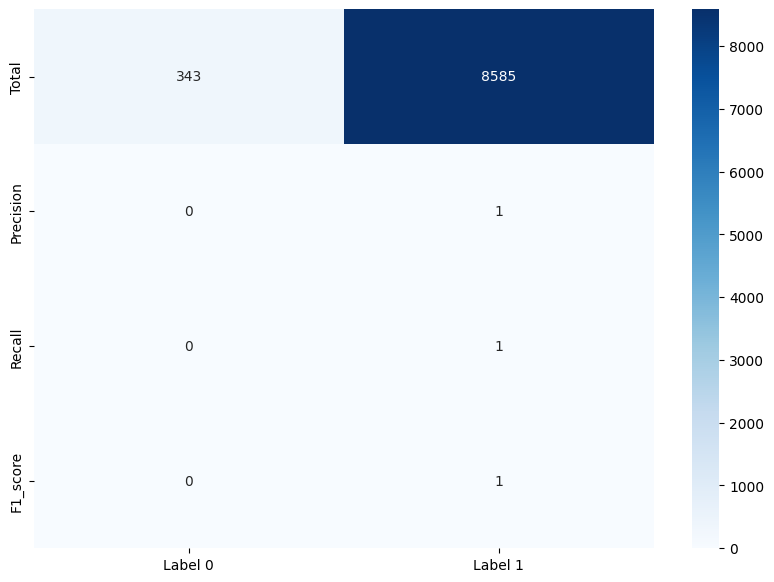

In [21]:
# ヒートマップで可視化
df_total = pd.DataFrame(
    np.array([total, precision, recall, f1_score]),
    index=['Total', 'Precision', 'Recall', 'F1_score'],
    columns=['Label 0','Label 1']
)

plt.figure(figsize=(10, 7))
sns.heatmap(df_total, annot=True, fmt='.0f', cmap='Blues');

## その他の評価指標

## ROC曲線とAUC

True Positive Rate(真陽性率）：

False Positive Rate(偽陽性率）：


In [22]:
y_proba = model.predict_proba(x_test)

In [23]:
y_proba[:3]


array([[0.02475571, 0.97524429],
       [0.0271331 , 0.9728669 ],
       [0.03116004, 0.96883996]])

In [24]:
fpr, tpr, threshold = metrics.roc_curve(t_test, y_proba[:,1])


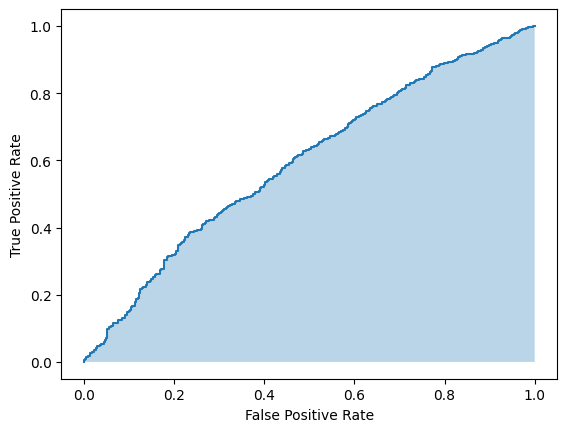

In [25]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr, tpr, alpha=0.3)

In [26]:
metrics.auc(fpr, tpr)


np.float64(0.5945212597061456)

## 不均衡データへのアプローチ
データ数を増やす

推論の確率に応じて、分類する閾値を調整する

データ数が少ないラベルに対して、重みを増やす（多いラベルに対して、減らす）

データ数が多いラベルのデータ数を減らす（DownSampling）

データ数が少ないラベルのデータ数をカサ増しする（OverSampling）

## 分類の閾値

In [27]:
y_proba = model.predict_proba(x_test)
y_proba[0]

array([0.02475571, 0.97524429])

Text(0, 0.5, 'Count')

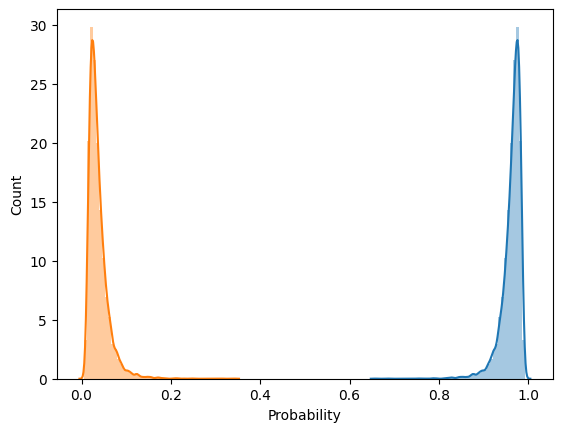

In [28]:
sns.distplot(y_proba[:, 1])
sns.distplot(y_proba[:, 0])
plt.xlabel('Probability')
plt.ylabel('Count')

<Axes: ylabel='Density'>

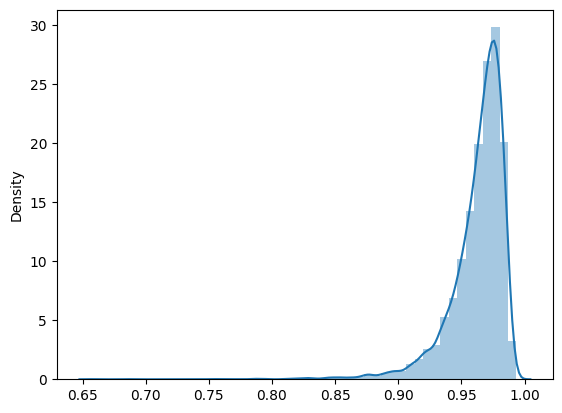

In [29]:
sns.distplot(y_proba[:, 1])


In [30]:
y_pred = (y_proba[:,1] > 0.95).astype('i')


In [31]:
np.unique(y_pred, return_counts=True)


(array([0, 1], dtype=int32), array([1735, 7193]))

In [32]:
print('accuracy : ', metrics.accuracy_score(t_test, y_pred))
print('recall : ', metrics.recall_score(t_test, y_pred, average=None))


accuracy :  0.7900985663082437
recall :  [0.29737609 0.80978451]


## 重みの調整

In [33]:
model = LogisticRegression(class_weight='balanced')


In [34]:
model.fit(x_train, t_train)


LogisticRegression(class_weight='balanced')

In [35]:
# 推論
y_pred = model.predict(x_test)

In [36]:
print('accuracy : ', metrics.accuracy_score(t_test, y_pred))
print('recall : ', metrics.recall_score(t_test, y_pred, average=None))

accuracy :  0.6137992831541219
recall :  [0.50728863 0.61805475]


## ダウンサンプリング
少ないカテゴリのサンプルのインデックスと、サンプルサイズを取得

多いカテゴリのサンプルからランダム抽出し、少ないカテゴリのサンプルサイズに合わせる

両者を結合して、1 つの新たなデータセットとして学習する

In [37]:
df_train = pd.DataFrame(x_train)
df_train['target'] = t_train
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,target
0,0.0,1.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,7.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,1.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,3.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,9.0,0.0,0.0,0.0,1.0,1.0,1.0,1
3,5.0,1.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,2.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,1
4,2.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.0,5.0,0.0,1.0,1.0,0.0,1.0,0.0,0


In [38]:
# target=0 のサンプルのインデックスを取得（少ない方のカテゴリ）
anomaly_indices = df_train[df_train['target'] == 0].index
num_records = len(anomaly_indices)

print(num_records)

765


In [39]:
# target=1 のサンプルのインデックスを取得（多い方のカテゴリ）
normal_indices = df_train[df_train['target'] == 1].index

sampled_indices = np.random.choice(normal_indices, num_records, replace=False)

len(sampled_indices)

765

In [40]:
total_indices = np.concatenate([anomaly_indices, sampled_indices])
print(len(total_indices))

1530


In [41]:
df_undersampled = df_train.loc[total_indices, :]


In [42]:
x_train_undersampled = df_undersampled.drop('target', axis=1).values
t_train_undersampled = df_undersampled['target'].values


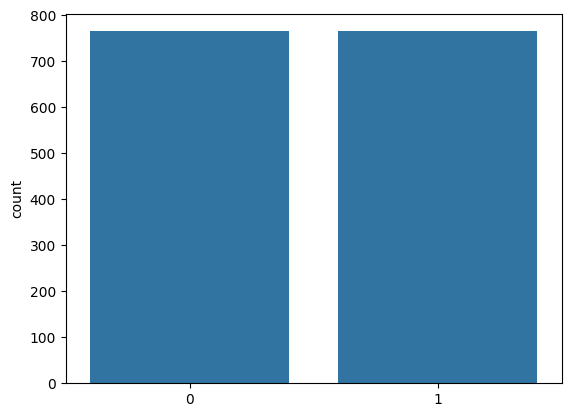

In [43]:
sns.countplot(x=t_train_undersampled);


In [44]:
# モデルの宣言
model = LogisticRegression()
# モデルの学習
model.fit(x_train_undersampled, t_train_undersampled)

LogisticRegression()

In [45]:
# 推論
y_pred = model.predict(x_test)

In [47]:
# AccuracyとRecallの確認
print('accuracy : ', metrics.accuracy_score(t_test, y_pred))
print('recall : ', metrics.recall_score(t_test, y_pred, average=None))


accuracy :  0.5883736559139785
recall :  [0.5393586  0.59033197]


## オーバーサンプリング

In [48]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0, k_neighbors=10)

In [49]:
x_train_oversampled, t_train_oversampled = smote.fit_resample(x_train, t_train)


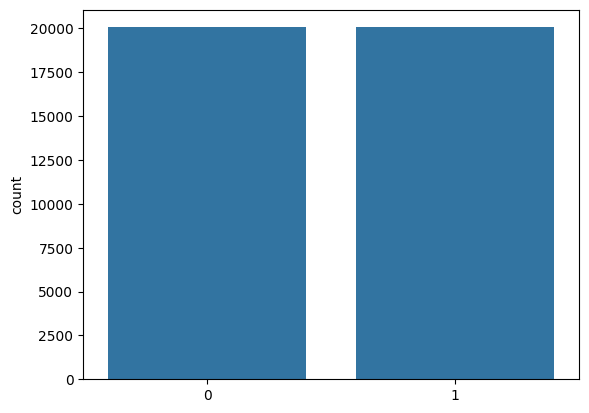

In [50]:
sns.countplot(x=t_train_oversampled);


In [51]:
# モデルの宣言
model = LogisticRegression()
# モデルの学習
model.fit(x_train_oversampled, t_train_oversampled)

LogisticRegression()

In [52]:
# 推論
y_pred = model.predict(x_test)

In [53]:
# Accuracy と Recall の確認
print('accuracy : ', metrics.accuracy_score(t_test, y_pred))
print('recall : ', metrics.recall_score(t_test, y_pred, average=None))


accuracy :  0.6107750896057348
recall :  [0.52769679 0.61409435]
